In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Dropout
import matplotlib.pyplot as plt


In [ ]:
# Download data from Yahoo Finance
data = yf.download('GOOG', start='2012-01-01', end='2022-12-21')

# Use only the 'Close' price for prediction
close_prices = data['Close'].values.reshape(-1, 1)

# Scale the data to the range (0, 1) for neural networks
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Prepare the dataset for training
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences of 60 days for X and the 61st day for y
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step, 0])
        y.append(data[i+time_step, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

# Reshape for LSTM/RNN input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Build the combined LSTM and RNN model
model = Sequential()

# Add LSTM layer
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Add RNN layer
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dropout(0.2))

# Add Dense layers for output
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model for 10 epochs
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0120 - val_loss: 0.0130
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0018 - val_loss: 0.0318
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0012 - val_loss: 0.0308
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 8.4481e-04 - val_loss: 0.0203
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 5.7609e-04 - val_loss: 0.0267
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 6.4488e-04 - val_loss: 0.0140
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 4.5726e-04 - val_loss: 0.0253
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 4.9243e-04 - val_loss: 0.0204
Epoch 9/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.4178e-04 - val_loss: 0.0109
Epoch 10/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 3.9384e-04 - val_loss: 0.0133


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


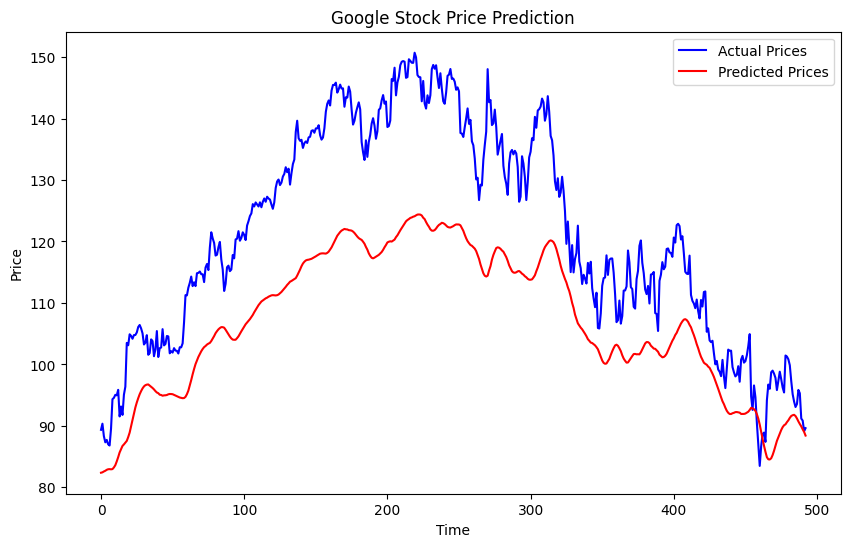

In [ ]:
# Predict the test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Inverse transform the y_test values for comparison
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Prices', color='blue')
plt.plot(predictions, label='Predicted Prices', color='red')
plt.title("Google Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


In [ ]:
# Convert predictions and actual prices to percentage change
predicted_change = np.sign(np.diff(predictions.flatten()))  # direction of change: 1 if up, -1 if down
actual_change = np.sign(np.diff(y_test_actual.flatten()))

# Calculate directional accuracy
accuracy = np.mean(predicted_change == actual_change)
print(f"Directional Accuracy: {accuracy *100:.4f}")



Directional Accuracy: 50.2033


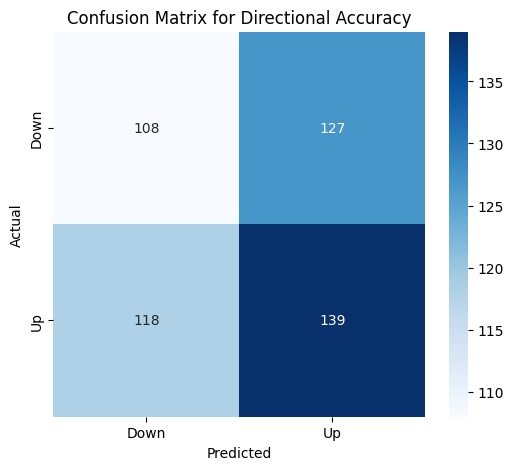

Directional Accuracy: 0.5020


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# Convert predictions and actual values to up/down (1/0)
# We are looking at whether the price goes up (1) or goes down (0)
predicted_changes = np.sign(np.diff(predictions.flatten()))  # direction of predicted price change: 1 for up, -1 for down
actual_changes = np.sign(np.diff(y_test_actual.flatten()))  # direction of actual price change: 1 for up, -1 for down

# Ensure that both predicted and actual have the same length for comparison
min_length = min(len(predicted_changes), len(actual_changes))
predicted_changes = predicted_changes[:min_length]
actual_changes = actual_changes[:min_length]

# Create confusion matrix
cm = confusion_matrix(actual_changes, predicted_changes)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title('Confusion Matrix for Directional Accuracy')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate accuracy (percentage of correct predictions)
accuracy = accuracy_score(actual_changes, predicted_changes)
print(f"Directional Accuracy: {accuracy:.4f}")


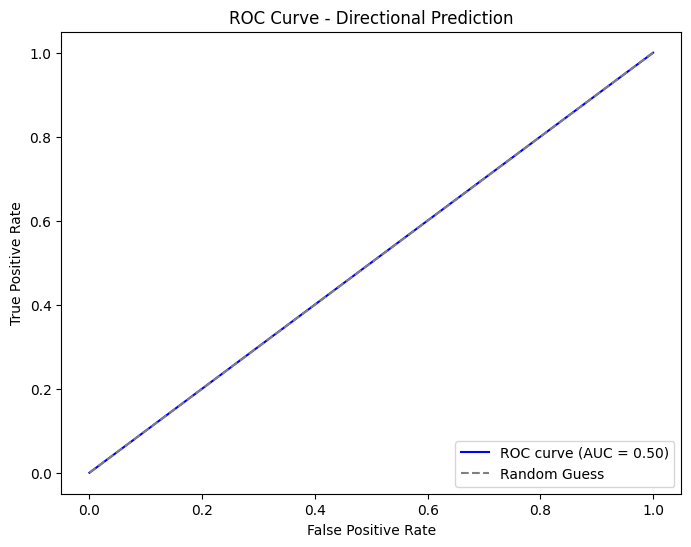

AUC Score: 0.5002


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert predictions and actual values to up/down (1/0) for ROC curve
predicted_changes = np.sign(np.diff(predictions.flatten()))  # direction of predicted price change: 1 for up, -1 for down
actual_changes = np.sign(np.diff(y_test_actual.flatten()))  # direction of actual price change: 1 for up, -1 for down

# Ensure that both predicted and actual have the same length for comparison
min_length = min(len(predicted_changes), len(actual_changes))
predicted_changes = predicted_changes[:min_length]
actual_changes = actual_changes[:min_length]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(actual_changes, predicted_changes)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Directional Prediction")
plt.legend(loc="lower right")
plt.show()

print(f"AUC Score: {roc_auc:.4f}")
